In [2]:
import math
import json

import re
import io
import os

from collections import namedtuple

from Bio.PDB import PDBParser, PDBList, Superimposer, vectors
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
from Bio.PDB.PDBIO import PDBIO, Select
from Bio.PDB.NeighborSearch import NeighborSearch
from Bio.PDB.Polypeptide import PPBuilder
from Bio.SeqUtils import IUPACData
from Bio import AlignIO

from ipywidgets import interact_manual

import nglview as nv
import pandas as pd
import seaborn as sns
import requests

sns.set(rc={'figure.figsize':(12, 8)})

In [3]:
def download(pdb_id, format):
    """ Descarga una estructura en el formato dado, y devuelve el path del archivo """
    pdbl = PDBList()
    path = pdbl.retrieve_pdb_file(pdb_id, pdir="data/", file_format=format)
    return path

myo_pdb = download("1mbo", "pdb")
myo_cif = download("1mbo", "mmCif")

Structure exists: 'data/pdb1mbo.ent' 
Structure exists: 'data/1mbo.cif' 


In [4]:
def parse_cif(path):
    return MMCIFParser(QUIET=True).get_structure("", path)

structure = parse_cif(myo_cif)

structure.header["name"]

'Structure and refinement of oxymyoglobin at 1.6 angstroms resolution'

In [5]:
mmcif_dict = MMCIF2Dict(myo_cif)

mmcif_dict["_struct.title"]

['Structure and refinement of oxymyoglobin at 1.6 angstroms resolution']

In [6]:
res = structure[0]["A"][89]
res

<Residue LEU het=  resseq=89 icode= >

In [7]:
res.get_resname()

'LEU'

In [8]:
res.id
# hetfield ("W": water, "H_": hetgroup, " ": standard), resseq, icode

(' ', 89, ' ')

In [9]:
atom = res["CA"]

print(atom)
print(atom.get_id())

atom.get_coord()

<Atom CA>
CA


array([10.157, 31.339,  5.075], dtype=float32)

In [10]:
atom.get_vector()

<Vector 10.16, 31.34, 5.07>

In [11]:
atom.get_bfactor()

12.19

# Actividad 1
## 1.
Utilice los comandos anteriores para tratar de identificar el residuo HEMO de la Mb y
obtener su id y full_id (hay algún otro residuo que NO es de la proteìna y NO es agua?)

In [12]:
hets = list(filter(lambda res: "H_" in res.id[0], structure.get_residues()))
hets

# Si, hay un sulfato y una molecula de oxigeno

[<Residue SO4 het=H_SO4 resseq=154 icode= >,
 <Residue HEM het=H_HEM resseq=155 icode= >,
 <Residue OXY het=H_OXY resseq=555 icode= >]

In [13]:
print(hets[1].id)
print(hets[1].full_id)

('H_HEM', 155, ' ')
('', 0, 'A', ('H_HEM', 155, ' '))


## 2.
Levante un PDB y obtenga: a) el número de cadenas, b) el número de residuos, c) número de átomos totales, d) número de átomos de proteìna, e) número de HETatoms, f) número de átomos de agua.

In [14]:
# Las funciones get_algo() en biopython devuelven generadores, un tipo de iterable que no tiene
# definido a priori su longitud. No definen el metodo len().
def iter_count(iterable):
    return sum(1 for _ in iterable)

print(structure.header["idcode"], structure.header["name"])
print("Cadenas:", iter_count(structure.get_chains()))
print("Residuos:", iter_count(structure.get_residues()))
print("Atomos totales:", iter_count(structure.get_atoms()))
print("Atomos de proteina:", sum(iter_count(res.get_atoms()) for res in structure.get_residues() if res.id[0] == " "))
print("HETatoms:", sum(iter_count(res.get_atoms()) for res in structure.get_residues() if "H_" in res.id[0]))
print("Atomos de aguas:", sum(iter_count(res.get_atoms()) for res in structure.get_residues() if res.id[0] == "W"))

# Otra forma de hacerlo es recorriendo con un for y sumando a varios contadores para cada caso pedido.

1MBO Structure and refinement of oxymyoglobin at 1.6 angstroms resolution
Cadenas: 1
Residuos: 490
Atomos totales: 1601
Atomos de proteina: 1217
HETatoms: 50
Atomos de aguas: 334


## 3.
Levante un PDB y determine la secuencia de aminoàcidos de cada cadena

In [15]:
def name1(name3):
    return IUPACData.protein_letters_3to1[name3.title()]
    
structure = parse_cif(download("1a3n", "mmCif"))
print(structure.header["idcode"], structure.header["name"])

for chain in structure.get_chains():
    seq = "".join(name1(res.get_resname()) for res in chain.get_residues() if res.id[0] == " ")
    print("Cadena", chain.get_id(), "-", seq)

Structure exists: 'data/1a3n.cif' 
1A3N DEOXY HUMAN HEMOGLOBIN
Cadena A - VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
Cadena B - HLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH
Cadena C - VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
Cadena D - HLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH


## 4.
Levante un PDB y obtenga un nuevo PDB que contenga “solo” los CA

In [16]:
class SelectCA(Select):
    # Heredar y overload de los metodos accept_x incluidos.
    def accept_atom(self, atom):
        return atom.id == "CA"

pdb_io = PDBIO()
pdb_io.set_structure(structure)
pdb_io.save("actividad1-4.pdb", select=SelectCA())

# Actividad 2

Cree una representación con el nglview, que contenga:

- La proteína en cartoon
- Las aguas en licorice
- El cofactor y/o ligando en vwd
- Los aminoácidos cercanos al cofactor y/o ligando en licorice

In [17]:
structure = parse_cif(download("1mbo", "mmCif"))
view = nv.show_biopython(structure)
view.clear_representations()
view.background = "black"
view.add_representation("cartoon", selection="protein", color="grey")

view.add_representation("surface", surfaceType="vws", selection="HEM", color="cyan")
view.add_representation("licorice", selection="OXY", color="red")

near_lig_pos = set()
ns = NeighborSearch(list(structure[0]["A"].get_atoms()))
for ligand_res in filter(lambda res: "H_HEM" in res.id[0], structure.get_residues()):
    for atom in ligand_res:
        s = ns.search(atom.coord, 5, "R")
        for res in s:
            resseq = res.get_full_id()[3][1]
            near_lig_pos.add(resseq)

for pos in near_lig_pos:
    view.add_representation("licorice", selection=str(pos), color="orange")


view.add_representation("surface", selection="ligand", color="cyan")
view.add_representation("licorice", selection="water", color="red")
view

Structure exists: 'data/1mbo.cif' 


NGLWidget(background='black')

# Actividad 3
## 1.
Busque en el PDB la oximioglobina (si es valiente la oxihemoglobina o algo equivalente), carguela en Biopython y calcule: distancia Fe-O, Angulo Fe-O-O, diedro N-Fe-O-O


In [18]:
structure = parse_cif(download("2dn1", "mmCif"))
print(structure.header["name"])

view = nv.show_biopython(structure)
view.clear_representations()
view.background = "black"
view.add_representation("cartoon", selection="protein", color="grey")
view.add_representation("ball+stick", selection="HEM", color="cyan")
view.add_representation("ball+stick", selection="OXY", color="red")
view

Structure exists: 'data/2dn1.cif' 
1.25A resolution crystal structure of human hemoglobin in the oxy form


NGLWidget(background='black')

In [19]:
# Las posiciones salen de ver la estructura en nglview

fe = list(filter(lambda a: a.id == "FE", structure[0]["A"][('H_HEM', 142, ' ')].get_atoms()))
nit = list(filter(lambda a: a.id[0] == "N", structure[0]["A"][('H_HEM', 142, ' ')].get_atoms()))
oxys = list(structure[0]["A"][('H_OXY', 143, ' ')].get_atoms())
print(fe)
print(oxys)
print(nit)

[<Atom FE>]
[<Atom O1>, <Atom O2>]
[<Atom NA>, <Atom NB>, <Atom NC>, <Atom ND>]


In [20]:
deg = lambda rads: rads*180/math.pi

# Cada oxigeno del O2
for i in range(2):
    print(f"distancia Fe-O#{i+1}:", fe[0] - oxys[i], "A")

print("angulo Fe-O-O:", deg(vectors.calc_angle(fe[0].get_vector(), oxys[0].get_vector(), oxys[1].get_vector())), "grados")

# Cada N de la protoporfirina
for i in range(4):
    print(f"diedro N#{i+1}-Fe-O-O:", deg(vectors.calc_dihedral(nit[i].get_vector(), fe[0].get_vector(), oxys[0].get_vector(), oxys[1].get_vector())), "grados")

distancia Fe-O#1: 1.8169678 A
distancia Fe-O#2: 2.71159 A
angulo Fe-O-O: 124.29449828574195 grados
diedro N#1-Fe-O-O: -144.77793825170625 grados
diedro N#2-Fe-O-O: 125.18782376997045 grados
diedro N#3-Fe-O-O: 33.863400231077875 grados
diedro N#4-Fe-O-O: -55.0446314625624 grados


## 2.
Genere una función que le permita obtener los ángulos diedros del enlace peptídico (Phi/psi) y represéntelos en un gráfico de ramachandran

In [21]:
def pep_dihedral(structure, chain):
    """ pep_diedral recibe una structure de biopython, y el nombre de una cadena.
    Devuelve un generador de tuplas (phi, psi) """
    
    prev_ca, prev_t = None, None
    chain_res = [res for res in structure[0][chain] if res.id[0] == " "]
    
    for i in range(len(chain_res) - 1):
        cr, nr = chain_res[i], chain_res[i+1]
        phi = deg(vectors.calc_dihedral( *(a.get_vector() for a in (cr["C"], nr["N"], nr["CA"], nr["C"]))))
        psi = deg(vectors.calc_dihedral(*(a.get_vector() for a in (cr["N"], cr["CA"], cr["C"], nr["N"]))))
        
        yield phi, psi

structure = parse_cif(download("3con", "mmCif"))
print(structure.header["name"])

for phi, psi in pep_dihedral(structure, "A"):
    print("phi", phi, "psi", psi)

Structure exists: 'data/3con.cif' 
Crystal structure of the human NRAS GTPase bound with GDP
phi -73.97433392322318 psi 169.42544563021667
phi -123.3388572746355 psi 144.64419593452035
phi -136.49914452560606 psi 144.40615983010048
phi -102.82593351414 psi 129.46937041603402
phi -107.80527702524483 psi 108.85990676938704
phi -132.79896366035118 psi 150.68042076997554
phi -109.54332786264406 psi 135.28075071211555
phi -129.19683643443875 psi 120.46711024073511
phi 144.81208231299019 psi 162.63268408058545
phi -61.298768136594184 psi 170.5564248072735
phi -58.450880295830146 psi 158.86943924135645
phi 87.29916536286414 psi 135.49250238834827
phi -78.38498555543015 psi 4.550704805910056
phi 113.8302581314706 psi -20.008522252917917
phi -54.35724156824258 psi 21.77283726491664
phi -67.44049514148148 psi -49.673794716752845
phi -62.3247207835999 psi -45.01072996145268
phi -65.31726285013609 psi -38.420336456843614
phi -59.33009396349832 psi -47.41960392024867
phi -66.60550588973601 psi -50.

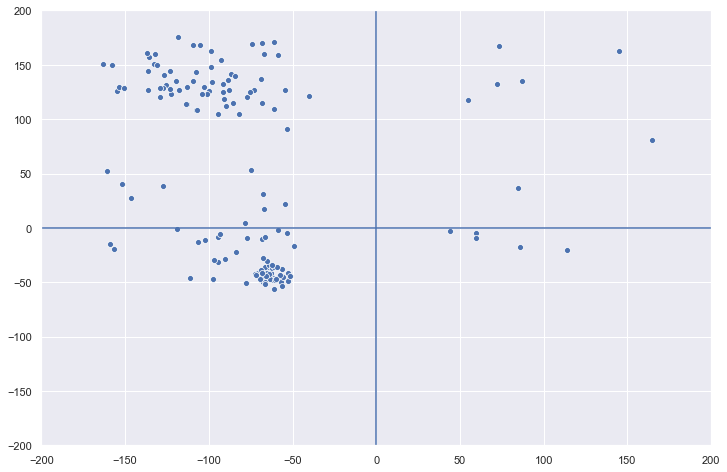

In [22]:
ax = sns.scatterplot(*zip(*pep_dihedral(structure, "A")))
ax.set(xlim=(-200, 200), ylim=(-200, 200))
ax.axhline(0)
ax.axvline(0)

## 3.
Utilizando valores de los ángulos Phi/psi calculados en el punto anterior determine los elementos de estructura secundaria correspondientes a cada posición de la secuencia

In [23]:
def sec(dihedrals, w=3):
    """ sec recibe el generador de angulos dihedros anterior y un tamaño w de ventana deslizante.
    En la ventana deslizante lleva la cuenta de que cuadrantes caen los ultimos w pares phi-psi.
    Devuelve un generador que por cada posicion da B=hoja beta, H=helice, T=turn/otro en base a que valor unanime contiene la ventana.
    """
    window = []
    for phi, psi in dihedrals:
        if len(window) >= w:
            window.pop(0)
        if phi < 0 and psi > 0:
            window.append("B")
        elif (phi < 0 and psi < 0) or (phi > 0 and psi > 0):
            window.append("H")
        else:
            window.append("T")  

        if window.count("B") == w:
            yield "B"
        elif window.count("H") == w:
            yield "H"
        else:
            yield "T"

for secstruct, res in zip(sec(pep_dihedral(structure, "A")), structure[0]["A"]):
    print(secstruct, res)

T <Residue MET het=  resseq=1 icode= >
T <Residue THR het=  resseq=2 icode= >
B <Residue GLU het=  resseq=3 icode= >
B <Residue TYR het=  resseq=4 icode= >
B <Residue LYS het=  resseq=5 icode= >
B <Residue LEU het=  resseq=6 icode= >
B <Residue VAL het=  resseq=7 icode= >
B <Residue VAL het=  resseq=8 icode= >
T <Residue VAL het=  resseq=9 icode= >
T <Residue GLY het=  resseq=10 icode= >
T <Residue ALA het=  resseq=11 icode= >
T <Residue GLY het=  resseq=12 icode= >
T <Residue GLY het=  resseq=13 icode= >
T <Residue VAL het=  resseq=14 icode= >
T <Residue GLY het=  resseq=15 icode= >
T <Residue LYS het=  resseq=16 icode= >
T <Residue SER het=  resseq=17 icode= >
H <Residue ALA het=  resseq=18 icode= >
H <Residue LEU het=  resseq=19 icode= >
H <Residue THR het=  resseq=20 icode= >
H <Residue ILE het=  resseq=21 icode= >
H <Residue GLN het=  resseq=22 icode= >
H <Residue LEU het=  resseq=23 icode= >
H <Residue ILE het=  resseq=24 icode= >
T <Residue GLN het=  resseq=25 icode= >
T <Residu

In [24]:
# Verificacion visual

view = nv.show_biopython(structure)
view.clear_representations()
view.add_representation("cartoon", selection="protein", color="grey")
view.background = "black"

sec_pos = {
    "H": [], "B": [], "T": []
}

for sec_struct, res in zip(sec(pep_dihedral(structure, "A")), structure[0]["A"]):
    sec_pos[sec_struct].append(res.full_id[3][1])

view.add_representation("backbone", aspectRatio=2, selection=" ".join(str(pos) for pos in sec_pos["H"]), color="red")
view.add_representation("backbone", aspectRatio=2, selection=" ".join(str(pos) for pos in sec_pos["B"]), color="green")
view.add_representation("backbone", aspectRatio=2, selection=" ".join(str(pos) for pos in sec_pos["T"]), color="blue")
view

NGLWidget(background='black')

# Actividad 4
Elija una familia de proteìnas que contenga al menos 10 estructuras correspondientes a
organismos distintos y realice las siguientes actividades:
## 1.
Alineamiento múltiple de todas las estructuras y estimación de una matriz de distancia
(RMSD de CA).

In [25]:
# http://pfam.xfam.org/family/PF00128
pdb_ids = ["1hny", "1c8q", "1amy", "2guy", "1clv", "1aqh", "1hvx", "1ht6", "4x9y", "1dhk", "1g5a"]
pdb_ids = [pdb_id.upper() for pdb_id in pdb_ids]

structures = {pdb_id: parse_cif(download(pdb_id, "mmCif")) for pdb_id in pdb_ids}

for pdb_id, structure in structures.items():
    print(pdb_id, structure.header["name"])

Structure exists: 'data/1hny.cif' 
Structure exists: 'data/1c8q.cif' 
Structure exists: 'data/1amy.cif' 
Structure exists: 'data/2guy.cif' 
Structure exists: 'data/1clv.cif' 
Structure exists: 'data/1aqh.cif' 
Structure exists: 'data/1hvx.cif' 
Structure exists: 'data/1ht6.cif' 
Structure exists: 'data/4x9y.cif' 
Structure exists: 'data/1dhk.cif' 
Structure exists: 'data/1g5a.cif' 
1HNY The structure of human pancreatic alpha-amylase at 1.8 angstroms resolution and comparisons with related enzymes
1C8Q STRUCTURE SOLUTION AND REFINEMENT OF THE RECOMBINANT HUMAN SALIVARY AMYLASE
1AMY CRYSTAL AND MOLECULAR STRUCTURE OF BARLEY ALPHA-AMYLASE
2GUY Orthorhombic crystal structure (space group P21212) of Aspergillus niger alpha-amylase at 1.6 A resolution
1CLV YELLOW MEAL WORM ALPHA-AMYLASE IN COMPLEX WITH THE AMARANTH ALPHA-AMYLASE INHIBITOR
1AQH ALPHA-AMYLASE FROM ALTEROMONAS HALOPLANCTIS
1HVX BACILLUS STEAROTHERMOPHILUS ALPHA-AMYLASE
1HT6 CRYSTAL STRUCTURE AT 1.5A RESOLUTION OF THE BARLEY AL

In [26]:
ppb=PPBuilder()
for struct in structures.values():
    for pp in ppb.build_peptides(struct[0]["A"]):
        print(">"+struct.header["idcode"], struct.header["name"])
        print(pp.get_sequence())
        print()

>1HNY The structure of human pancreatic alpha-amylase at 1.8 angstroms resolution and comparisons with related enzymes
YSPNTQQGRTSIVHLFEWRWVDIALECERYLAPKGFGGVQVSPPNENVAIYNPFRPWWERYQPVSYKLCTRSGNEDEFRNMVTRCNNVGVRIYVDAVINHMCGNAVSAGTSSTCGSYFNPGSRDFPAVPYSGWDFNDGKCKTGSGDIENYNDATQVRDCRLTGLLDLALEKDYVRSKIAEYMNHLIDIGVAGFRLDASKHMWPGDIKAILDKLHNLNSNWFPAGSKPFIYQEVIDLGGEPIKSSDYFGNGRVTEFKYGAKLGTVIRKWNGEKMSYLKNWGEGWGFVPSDRALVFVDNHDNQRGHGAGGASILTFWDARLYKMAVGFMLAHPYGFTRVMSSYRWPRQFQNGNDVNDWVGPPNNNGVIKEVTINPDTTCGNDWVCEHRWRQIRNMVIFRNVVDGQPFTNWYDNGSNQVAFGRGNRGFIVFNNDDWSFSLTLQTGLPAGTYCDVISGDKINGNCTGIKIYVSDDGKAHFSISNSAEDPFIAIHAESKL

>1C8Q STRUCTURE SOLUTION AND REFINEMENT OF THE RECOMBINANT HUMAN SALIVARY AMYLASE
YSSNTQQGRTSIVHLFEWRWVDIALECERYLAPKGFGGVQVSPPNENVAIHNPFRPWWERYQPVSYKLCTRSGNEDEFRNMVTRCNNVGVRIYVDAVINHMCGNAVSAGTSSTCGSYFNPGSRDFPAVPYSGWDFNDGKCKTGSGDIENYNDATQVRDCRLSGLLDLALGKDYVRSKIAEYMNHLIDIGVAGFRIDASKHMWPGDIKAILDKLHNLNSNWFPEGSKPFIYQEVIDLGGEPIKSSDYFGNGRVTEFKYGAKLGTVIRKWNGEKMSYLKNWGEGWGFMPSDRALVFVDNHDNQR

In [27]:
# Alineamiento multiple de las secuencias anteriores con Clustal Omega
# Trabajo hecho: https://www.ebi.ac.uk/Tools/services/web/toolresult.ebi?jobId=clustalo-I20200926-022534-0245-39620853-p1m

aln_txt = requests.get("https://www.ebi.ac.uk/Tools/services/rest/clustalo/result/clustalo-I20200926-022534-0245-39620853-p1m/aln-clustal_num").text

aln = AlignIO.read(io.StringIO(aln_txt), "clustal")
pdb_ids = [record.id for record in aln]
pdb_ids

['1AQH',
 '1CLV',
 '1DHK',
 '1HNY',
 '4X9Y',
 '1C8Q',
 '1G5A',
 '1HVX',
 '2GUY',
 '1AMY',
 '1HT6']

In [28]:
indexes = {pdb_id: 0 for pdb_id in pdb_ids}

ref_atoms = []
mov_atoms = []

# https://biopython-cn.readthedocs.io/zh_CN/latest/en/chr06.html

def identity_100(seq):
    """ identity_100 recibe una string y devuelve True si todos los caracteres son iguales.
    False de lo contrario, o si contiene un - """
    if "-" in seq:
        return False
    for x in seq:
        if x != seq[0]:
            return False
    return True

eq_atoms = []
# indexes contiene posiciones equivalentes entre cada pdb a medida que se itera el alineamiento multiple
for i in range(len(aln[0])):
    col = aln[:,i]
    
    for aa, pdb_id in zip(list(col), pdb_ids):
        if aa != "-":
            indexes[pdb_id] += 1
    
    if identity_100(col):
        print(i, col)
        print(indexes)
        
        cas = []
        for pdb_id, i in indexes.items():
            res = [r for r in structures[pdb_id][0]["A"] if r.id[0] == " "][i-1]
            print(res)
            cas.append(res["CA"])
        
        eq_atoms.append(cas)
        print()



126 GGGGGGGGGGG
{'1AQH': 28, '1CLV': 35, '1DHK': 35, '1HNY': 35, '4X9Y': 35, '1C8Q': 35, '1G5A': 126, '1HVX': 37, '2GUY': 56, '1AMY': 33, '1HT6': 34}
<Residue GLY het=  resseq=28 icode= >
<Residue GLY het=  resseq=36 icode= >
<Residue GLY het=  resseq=36 icode= >
<Residue GLY het=  resseq=36 icode= >
<Residue GLY het=  resseq=36 icode= >
<Residue GLY het=  resseq=36 icode= >
<Residue GLY het=  resseq=126 icode= >
<Residue GLY het=  resseq=37 icode= >
<Residue GLY het=  resseq=56 icode= >
<Residue GLY het=  resseq=33 icode= >
<Residue GLY het=  resseq=34 icode= >

134 PPPPPPPPPPP
{'1AQH': 36, '1CLV': 43, '1DHK': 43, '1HNY': 43, '4X9Y': 43, '1C8Q': 43, '1G5A': 134, '1HVX': 45, '2GUY': 64, '1AMY': 41, '1HT6': 42}
<Residue PRO het=  resseq=36 icode= >
<Residue PRO het=  resseq=44 icode= >
<Residue PRO het=  resseq=44 icode= >
<Residue PRO het=  resseq=44 icode= >
<Residue PRO het=  resseq=44 icode= >
<Residue PRO het=  resseq=44 icode= >
<Residue PRO het=  resseq=134 icode= >
<Residue PRO 

In [29]:
pdb_eq_atoms = list(zip(*eq_atoms))

ref_atoms = pdb_eq_atoms[0] # de 1AQH

align_out_path = "align_out/"
if not os.path.exists(align_out_path):
    os.mkdir(align_out_path)
    
for pdb_id, atoms in zip(pdb_ids, pdb_eq_atoms):
    sup = Superimposer()
    sup.set_atoms(ref_atoms, atoms)
    model = structures[pdb_id][0]
    sup.apply(model.get_atoms())
    
    pdb_io = PDBIO()
    pdb_io.set_structure(structures[pdb_id]) 
    
    pdb_io.save(f"align_out/align_{pdb_id}.pdb")

In [30]:
# Superposicion de estructuras
view = nv.show_biopython(structures["1AQH"])

for file in os.listdir(align_out_path):
    if file.endswith(".pdb"):
        view.add_component(os.path.join(align_out_path, file))

view

NGLWidget()

## 2.
Compare el área accesible al solvente (SASA) total con el radio de giro (ROG) para
cada una de las estructuras.

In [31]:
# SASA

# El script de Bash sasa.sh corre freesasa para todos los PDBs del directorio
# y devuelve los resultados en forma de archivos JSON.

if os.system("freesasa -v") == 0: # esta instalado
    os.system(f"cd {align_out_path} && ./sasa.sh")

pdb_sasa = {}
for file in os.listdir(align_out_path):
    if file.endswith("sasa.json"):
        r = json.load(open(os.path.join(align_out_path, file)))
        pdb_id = re.search("_(.{4}).pdb", file).group(1)
        pdb_sasa[pdb_id] = r["results"][0]["structure"][0]["area"]["total"]

pdb_sasa

{'1G5A': 24899.057251602808,
 '1CLV': 16859.989607509673,
 '2GUY': 16556.50580732047,
 '1AQH': 16331.214206312536,
 '1HNY': 17872.539138356762,
 '1AMY': 14994.280829666593,
 '4X9Y': 17755.67894127393,
 '1C8Q': 17873.230358031964,
 '1HT6': 16106.759539648932,
 '1DHK': 23948.715986571882,
 '1HVX': 17502.288248079272}

In [32]:
# ROG
import pytraj as pt

pdb_rog = {}
for file in os.listdir(align_out_path):
    if file.endswith(".pdb"):
        pdb = pt.load(os.path.join(align_out_path, file))
        pdb_id = re.search("_(.{4}).pdb", file).group(1)
        pdb_rog[pdb_id] = pt.radgyr(pdb)[0]

pdb_rog

{'1AMY': 21.883580892076026,
 '1CLV': 22.425691443423272,
 '1DHK': 26.72745297777032,
 '1HNY': 23.127829162182355,
 '1C8Q': 22.91723957347072,
 '1G5A': 26.371149690905735,
 '1HVX': 24.435557736247315,
 '1AQH': 22.806528847526128,
 '4X9Y': 22.971522457572338,
 '2GUY': 22.80420703548057,
 '1HT6': 22.627211339990666}

In [33]:
pdb_ids = list(pdb_sasa.keys())
df = pd.DataFrame({"pdb": pdb_ids,
                   "sasa": [pdb_sasa[pdb_id] for pdb_id in pdb_ids],
                   "rog": [pdb_rog[pdb_id] for pdb_id in pdb_ids]})
df

,pdb,sasa,rog
0,1G5A,24899.057252,26.371150
1,1CLV,16859.989608,22.425691
2,2GUY,16556.505807,22.804207
3,1AQH,16331.214206,22.806529
4,1HNY,17872.539138,23.127829
5,1AMY,14994.280830,21.883581
6,4X9Y,17755.678941,22.971522
7,1C8Q,17873.230358,22.917240
8,1HT6,16106.759540,22.627211
9,1DHK,23948.715987,26.727453


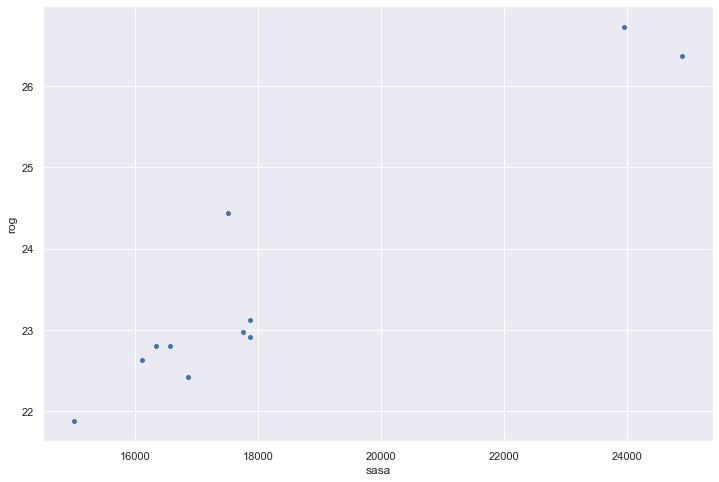

In [34]:
sns.scatterplot(df["sasa"], df["rog"])

## 3.
Clasifique cada uno de los residuos de la proteína como expuesto/enterrado utilizando
como parámetro el SASA y represente en un gráfico la frecuencia de aparición de cada
aminoácido para cada categoría.

In [35]:
ResidueSASA = namedtuple("ResidueSASA", " ".join([
    "name", "pos",
    "all_abs", "all_rel",
    "side_abs", "side_rel",
    "main_abs", "main_rel",
    "apolar_abs", "apolar_rel",
    "polar_abs", "polar_rel"
]))

if os.system("freesasa -v") == 0:
    os.system(f"cd {align_out_path} && ./sasa_res.sh")

pdb_res_sasa = {}
for file in os.listdir(align_out_path):
    if file.endswith("sasa_res.out"):
        pdb_id = re.search("_(.{4}).pdb", file).group(1)
        
        with open(os.path.join(align_out_path, file)) as f:
            for line in f:
                if line.startswith("RES"):
                    name, pos, areas = line[4:7], int(line[9:13].strip()), line[13:].split()
                    fields = [name, pos] + [float(x) if x != "N/A" else math.nan for x in areas]
                    
                    rs = ResidueSASA(*fields)
                    
                    if pdb_id not in pdb_res_sasa:
                        pdb_res_sasa[pdb_id] = {}
                    pdb_res_sasa[pdb_id][rs.pos] = rs

In [36]:
pdb_res_sasa["1G5A"][33]

ResidueSASA(name='SER', pos=33, all_abs=24.3, all_rel=20.5, side_abs=24.3, side_rel=32.4, main_abs=0.0, main_rel=0.0, apolar_abs=6.29, apolar_rel=13.4, polar_abs=18.02, polar_rel=25.2)

In [37]:
# Construir df con todos los residuos

sasa_residues = []
for pdb_id, pdb in pdb_res_sasa.items():
    for pos, res in pdb.items():
        sasa_residues.append((pdb_id, *res))

cols = [
    "pdb", "name", "pos",
    "all_abs", "all_rel",
    "side_abs", "side_rel",
    "main_abs", "main_rel",
    "apolar_abs", "apolar_rel",
    "polar_abs", "polar_rel"
]

def sasa_dataset(cutoff):
    df = pd.DataFrame(sasa_residues, columns=cols)
    df["exposed"] = df["all_rel"] > cutoff
    dfaa = df.groupby(["name"]).mean()
    dfaa["source"] = "sasa"
    dfaa["name"] = dfaa.index
    return dfaa

sasa_dataset(50)

,pos,all_abs,all_rel,side_abs,side_rel,main_abs,main_rel,apolar_abs,apolar_rel,polar_abs,polar_rel,exposed,source,name
name,,,,,,,,,,,,,,
ALA,246.339523,24.289390,22.332095,15.380875,23.737931,8.908488,20.263660,18.253714,25.703183,6.035862,15.988594,0.164456,sasa,ALA
ARG,236.329060,55.110769,23.140598,48.889402,24.921795,6.221239,14.813248,17.636282,24.101709,37.474359,22.709402,0.081197,sasa,ARG
ASN,258.024390,56.435583,38.920054,46.340271,44.782114,10.095095,24.306233,13.898130,33.451220,42.537453,41.116260,0.322493,sasa,ASN
ASP,248.366748,50.344303,35.266748,41.114670,40.922494,9.229511,21.825428,14.950465,35.186308,35.394156,35.297311,0.315403,sasa,ASP
CYS,253.963855,12.727349,9.627711,6.038795,6.734940,6.688554,15.720482,3.302530,8.369880,9.424699,10.165060,0.012048,sasa,CYS
GLN,231.790055,55.643149,31.113812,48.262873,35.271823,7.380387,17.566298,16.016906,34.094475,39.625912,30.054144,0.226519,sasa,GLN
GLU,223.217822,59.694010,34.270297,50.937871,38.536139,8.756485,20.848515,21.438861,41.469307,38.255198,31.236634,0.321782,sasa,GLU
GLY,255.978805,26.914027,33.189981,0.000000,NaN,26.914027,33.189981,16.521522,45.338150,10.392775,23.275915,0.300578,sasa,GLY
HIS,253.769231,33.216538,18.150769,28.912385,20.096154,4.304154,11.013846,20.586538,21.220769,12.629923,14.693077,0.092308,sasa,HIS


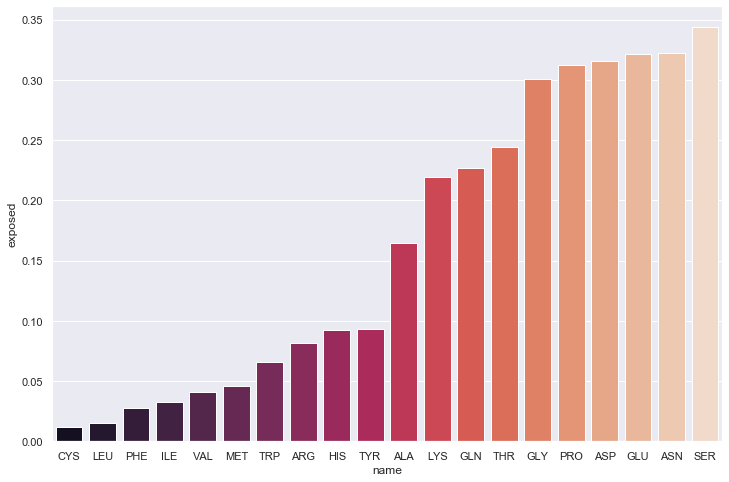

In [38]:
# Porcentaje de exposicion al solvente promedio de la cadena lateral para cada aminoacido
dfaa = sasa_dataset(50).sort_values(by="exposed")
sns.barplot(x=dfaa.index, y="exposed", data=dfaa, palette="rocket")

In [39]:
def water_dataset(cutoff):
    ns = NeighborSearch(list(structures["1HVX"][0]["A"].get_atoms()))
    w_residues = []
    for pdb_id, structure in structures.items():
        for res in filter(lambda res: res.id[0] == " ", structure[0]["A"].get_residues()):
            exposed = False
            for atom in res:
                s = ns.search(atom.coord, cutoff, "R")
                for near_res in s:
                    if near_res.id[0] == "W":
                        exposed = True
            w_residues.append((pdb_id, res.get_resname(), res.full_id[3][1], exposed))

    df = pd.DataFrame(w_residues, columns=["pdb", "name", "pos", "exposed"])
    dfaa = df.groupby(["name"]).mean()
    dfaa = dfaa.sort_values(by="exposed")
    dfaa["source"] = "water"
    dfaa["name"] = dfaa.index
    return dfaa

def plot_sasa_water(sasa_cutoff, water_cutoff):
    df = pd.concat([water_dataset(water_cutoff)[["name", "exposed", "source"]], sasa_dataset(sasa_cutoff)[["name", "exposed", "source"]]])
    sns.barplot(x="name", y="exposed", data=df, hue="source", palette="rocket")

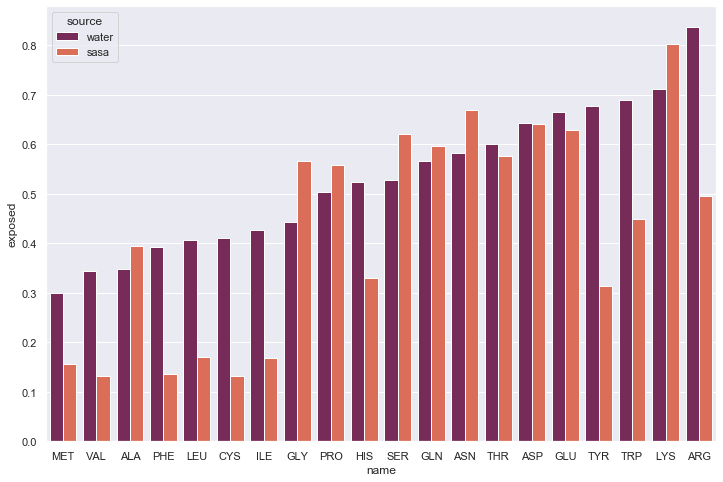

In [40]:
plot_sasa_water(20, 3)

In [41]:
if os.system("freesasa -v") == 0:
    interact_manual(plot_sasa_water, sasa_cutoff=(0,100), water_cutoff=(1,5));
else:
    print("FreeSASA no instalado")

interactive(children=(IntSlider(value=50, description='sasa_cutoff'), IntSlider(value=3, description='water_cu…

## 4.
Identifique los aminoácidos que pertenecen al sitio activo para cada una de las
estructuras de la familia elegida.

En las anotaciones en UniProt para la alfa amilasa humana (https://www.uniprot.org/uniprot/P04745) se halla que los residuos con función catalítica son el Asp-212 como nucleófilo y Glu-248 como donor de protones. Dichas posiciones son respecto a la secuencia canónica, corresponden a la posición 355 y 411, respectivamente para el alineamiento múltiple realizado previamente.

Para el caso de la posición 411 del alineamiento la identidad no es tan alta y además en tres de las secuencias se encuentra un gap, probablemente otro residuo estructuralmente cercano reemplace su función.





In [42]:
view = nv.show_biopython(structures["1HNY"])
view.clear_representations()
view.background = "black"
view.add_representation("cartoon", selection="protein", color="grey")
view.add_representation("surface", selection="197 233", color="orange")
view

NGLWidget(background='black')

Como criterio para definir los sitios activos, vamos a tomar los residuos que esten a menos de 5 Angstrom de distancia del nucleofilo.

In [43]:
# En un print del punto 4.1 se obtuvo que para la posicion 355 del alineamiento global
# las siguientes posiciones son equivalentes:
cat_pos = {'1AQH': 174, '1CLV': 184, '1DHK': 196, '1HNY': 196, '4X9Y': 196, '1C8Q': 196, '1G5A': 286, '1HVX': 234, '2GUY': 206, '1AMY': 179, '1HT6': 180}

pdb_active_site = {}
for pdb_id, pos in cat_pos.items():
    res = [r for r in structures[pdb_id][0]["A"] if r.id[0] == " "][pos-1]
    
    near_residues = set()
    ns = NeighborSearch(list(structures[pdb_id][0]["A"].get_atoms()))
    for atom in res:
        s = filter(lambda r: r.id[0] == " ", ns.search(atom.coord, 5, "R"))
        for near_res in s:
            near_residues.add(near_res)
    print("====>", pdb_id)
    print(near_residues)
    pdb_active_site[pdb_id] = near_residues
    print()



====> 1AQH
{<Residue LEU het=  resseq=86 icode= >, <Residue ALA het=  resseq=175 icode= >, <Residue TYR het=  resseq=50 icode= >, <Residue ASP het=  resseq=174 icode= >, <Residue HIS het=  resseq=89 icode= >, <Residue PHE het=  resseq=173 icode= >, <Residue THR het=  resseq=85 icode= >, <Residue SER het=  resseq=176 icode= >, <Residue ASN het=  resseq=88 icode= >, <Residue ARG het=  resseq=172 icode= >, <Residue ASP het=  resseq=84 icode= >, <Residue GLU het=  resseq=200 icode= >, <Residue ILE het=  resseq=87 icode= >}

====> 1CLV
{<Residue ASP het=  resseq=94 icode= >, <Residue MET het=  resseq=190 icode= >, <Residue ALA het=  resseq=186 icode= >, <Residue VAL het=  resseq=96 icode= >, <Residue ASP het=  resseq=185 icode= >, <Residue ALA het=  resseq=95 icode= >, <Residue ALA het=  resseq=187 icode= >, <Residue TYR het=  resseq=60 icode= >, <Residue ARG het=  resseq=183 icode= >, <Residue VAL het=  resseq=184 icode= >, <Residue ILE het=  resseq=97 icode= >, <Residue ASN het=  resseq=9

In [44]:
view = nv.show_biopython(structures["1HT6"])
view.clear_representations()
view.background = "black"
view.add_representation("surface", probeRadius=0.2, selection="protein", color="grey")
view.add_representation("surface", probeRadius=1.3, selection=" ".join(str(res.full_id[3][1]) for res in pdb_active_site["1HT6"]), color="orange")
view

NGLWidget(background='black')